In [42]:
!pip install groq
!pip install language_tool_python
!pip install ipython
!pip install -q -U google-generativeai
!pip install --upgrade transformers sentencepiece datasets[audio]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.2
    Uninstalling transformers-4.46.2:
      Successfully uninstalled transformers-4.46.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are

In [8]:
from groq import Groq
from google.colab import userdata

api_key = userdata.get('GROQ_API_KEY')
client = Groq(api_key=api_key)
def autio_to_text(filename:str):
  filename = "/content/vantage-with-palki-sharma.mp3"
  with open(filename, "rb") as file:
      transcription = client.audio.transcriptions.create(
        file=(filename, file.read()),
        model="whisper-large-v3-turbo",
        response_format="json",
        temperature=0.0
      )
      return transcription.text


In [6]:
import language_tool_python
tool = language_tool_python.LanguageTool('en-US')

def correct_text(text):
  matches = tool.check(text)
  corrected_text = tool.correct(text)
  return corrected_text


INFO:language_tool_python.download_lt:Unzipping /tmp/tmppkarpqh_.zip to /root/.cache/language_tool_python.
INFO:language_tool_python.download_lt:Downloaded https://www.languagetool.org/download/LanguageTool-6.4.zip to /root/.cache/language_tool_python.


In [11]:
def translator(text,language):
  chat_completion = client.chat.completions.create(
      messages=[
          {
              "role": "system",
              "content": f"you are a helpful translator. Translate the below provide data in {language}"
          },
          {
              "role": "user",
              "content": f"## TEXT NEED TO BE TRANSLATED\n\n{text}",
          }
      ],
      model="llama3-8b-8192",
      temperature=0.5,
      max_tokens=1024,
      top_p=1,
      stop=None,
      stream=False,
  )
  return chat_completion.choices[0].message.content

In [39]:
import base64
import matplotlib.pyplot as plt
import matplotlib.image as img
import google.generativeai as genai

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')

genai.configure(api_key=GOOGLE_API_KEY)
def image_to_text(image_path:str):
  temp_image = img.imread(image_path)
  plt.imshow(temp_image)

  with open(image_path, "rb") as image_file:
    base64_image = base64.b64encode(image_file.read()).decode('utf-8')

  chat_completion = client.chat.completions.create(
  messages=[
      {
          "role": "user",
          "content": [
              {"type": "text", "text": "Extract Exact Text from IMAGE"},
              {
                  "type": "image_url",
                  "image_url": {
                      "url": f"data:image/jpeg;base64,{base64_image}",
                  },
              },
          ],
      }
  ],
    model="llama-3.2-11b-vision-preview",
)

  return chat_completion.choices[0].message.content

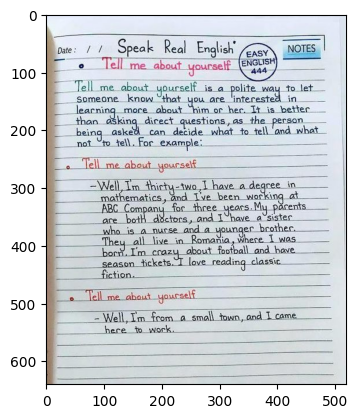

In [40]:
text = image_to_text("/content/test.jpg")

In [41]:
text

"**Extracted Text:**\n\nWell, I thirty-two. I have a degree in mathematics, and I've been working at ABC Company for three years. My parents are both doctors, and I have a sister who is a nurse and a younger brother. They all live in Romania, where I was born. I'm crazy about football and have season tickets. I love reading classic fiction.\n\nWell, I'm from a small town, and I came here to work."

In [53]:
import torch
from transformers import pipeline
from datasets import load_dataset
import soundfile as sf
def text_to_speech(text,path:str):
  synthesiser = pipeline("text-to-speech", "microsoft/speecht5_tts")

  embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
  speaker_embedding = torch.tensor(embeddings_dataset[7306]["xvector"]).unsqueeze(0)
  speech = synthesiser(text[:596], forward_params={"speaker_embeddings": speaker_embedding})
  sf.write(path, speech["audio"], samplerate=speech["sampling_rate"])

In [54]:
def speech_to_speech(filename:str,language:str="hindi"):
  text = autio_to_text(filename)
  corrected_text = correct_text(text)
  translated_text = translator(corrected_text,language)
  text_to_speech(translated_text, filename[:20]+".wav")


In [55]:
speech_to_speech("/content/vantage-with-palki-sharma.mp3")

In [57]:
def image_to_speech(filename:str,language:str="hindi"):
  text = image_to_text(filename)
  corrected_text = correct_text(text)
  translated_text = translator(corrected_text,language)
  text_to_speech(translated_text, filename[:20]+".wav")

In [ ]:
image_to_speech("/content/test.jpg")